In [ ]:
# Standard library
import os
import sys
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Statistics and modeling
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import powerlaw as pl  # Avoids conflict with scipy.stats.powerlaw

# Get the current working directory and then go up to the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

## Fill Probability

In [4]:

message_data = pd.read_csv("combined_messages_.csv")
# message_data = pd.read_csv("combined_messages_2024-08-12.csv")


message_column_names = [
    'Time',         # Seconds after midnight with decimal precision
    'EventType',    # Type of event (1 to 7 as described)
    'OrderID',      # Unique order reference number
    'Size',         # Number of shares
    'Price',        # Dollar price times 10000
    'Direction',     # -1 for sell, 1 for buy
    # 'NotUsed',      # Not used, for alignment purposes
]

message_data.columns = message_column_names

print(message_data.shape)

# Drop first row
message_data = message_data.drop(0)

# Drop NotUsed column
# message_data = message_data.drop(columns=['NotUsed'])

(32684909, 6)


In [5]:
book_data = pd.read_csv("combined_orderbooks_.csv")
# book_data = pd.read_csv("combined_orderbooks_2024-08-12.csv")

# Define the column names up to level 10
column_names = []
for level in range(1, 11):
    column_names.extend([
        f'AskPrice{level}', f'AskSize{level}',
        f'BidPrice{level}', f'BidSize{level}'
    ])

# Set the column names for the DataFrame
book_data.columns = column_names

print(book_data.shape)

# Drop first row
book_data = book_data.drop(0)

(32684909, 40)


In [6]:
# Directly copy the 'Time' column from message_data to book_data
book_data['Time'] = message_data['Time']

# Reorder columns to make 'Time' the first column
# This assumes book_data originally had unnamed columns
columns = ['Time'] + list(book_data.columns[:-1])  # Move 'Time' to the first position
book_data = book_data[columns]

message_data['Time'] = pd.to_datetime(message_data['Time'])
book_data['Time'] = pd.to_datetime(book_data['Time'])

message_data.set_index('Time', inplace=True)
book_data.set_index('Time', inplace=True)

In [7]:
# Mid-price calculation
book_data['MidPrice'] = (book_data['AskPrice1'] + book_data['BidPrice1']) / 2

message_data['MidPrice'] = book_data['MidPrice']

message_data['BestBid'] = book_data['BidPrice1']

message_data['BestAsk'] = book_data['AskPrice1']

In [8]:
book_data.head()

,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,AskSize3,...,BidSize8,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10,MidPrice
Time,,,,,,,,,,,,,,,,,,,,,
2024-08-01 09:30:00.001184000,1892900,382,1892800,103,1893000,729,1892500,1,1893300,100,...,108,1897000,200,1890900,7,1898000,200,1890600,1,1892850.0
2024-08-01 09:30:00.001447680,1892900,382,1892800,103,1893000,729,1892500,1,1893300,100,...,108,1897000,200,1890900,7,1898000,200,1890600,1,1892850.0
2024-08-01 09:30:00.004858368,1892900,370,1892800,103,1893000,729,1892500,1,1893300,100,...,108,1897000,200,1890900,7,1898000,200,1890600,1,1892850.0
2024-08-01 09:30:00.005389568,1892900,370,1892800,100,1893000,729,1892500,1,1893300,100,...,108,1897000,200,1890900,7,1898000,200,1890600,1,1892850.0
2024-08-01 09:30:00.005389568,1892900,370,1892800,99,1893000,729,1892500,1,1893300,100,...,108,1897000,200,1890900,7,1898000,200,1890600,1,1892850.0


In [9]:
message_data.head()

,EventType,OrderID,Size,Price,Direction,MidPrice,BestBid,BestAsk
Time,,,,,,,,
2024-08-01 09:30:00.001184000,3,31126325,100,1892700,1,1892850.0,1892800,1892900
2024-08-01 09:30:00.001447680,1,31486045,80,1895000,-1,1892850.0,1892800,1892900
2024-08-01 09:30:00.004858368,4,31388241,12,1892900,-1,1892850.0,1892800,1892900
2024-08-01 09:30:00.005389568,4,12753345,3,1892800,1,1892850.0,1892800,1892900
2024-08-01 09:30:00.005389568,4,31485689,1,1892800,1,1892850.0,1892800,1892900


In [10]:
# Percentage of event 4 and 5
# EventType 4 is visible
# EventType 5 is invisible

visible_mo_count = message_data[message_data['EventType'] == 4].shape[0]
invisible_mo_count = message_data[message_data['EventType'] == 5].shape[0]

print(f"Visible Market Orders: {visible_mo_count}")
print(f"Invisible Market Orders: {invisible_mo_count}")
print(f"Percentage of Visible Market Orders: {visible_mo_count / (visible_mo_count + invisible_mo_count) * 100:.2f}%")

Visible Market Orders: 2021461
Invisible Market Orders: 332787
Percentage of Visible Market Orders: 85.86%


## Fill Probability, filled within a defined time interval

In [11]:
# Step 1: Calculate depth at posting (integer verified)
message_data['DepthAtPosting'] = message_data.apply(
    lambda row: abs(row['Price'] - row['BestBid']) // 100 if row['Direction'] == 1 
    else abs(row['Price'] - row['BestAsk']) // 100,
    axis=1
)    

In [12]:
# Initialize data structures with modified variable names
filled_depth_count_v2 = {}  # Depth -> Total filled size 
# Modified for event 4 only

posted_depth_count_v2 = {}  # Depth -> Total posted size
# Modfied for event 1, 2, 3

order_depth_map_v2 = {}     # Order ID -> Depth posted
# No modification as the depth is fixed at posting (but can be deleted for event 3)


order_size_map_v2 = {}      # Order ID -> Size posted
# Added for event 1, and modified for event 2, deleted for event 3, modified for event 4

orderid_time_dict_v2 = {}   # Order ID -> Timestamp when posted
# Added for event 1, deleted for event 3, or when iterating thru in event 4 for efficiency sake

filled_timestamp_set = set()  # Set to store timestamps of filled orders

# Configurable time threshold (e.g., 1 minute)
time_threshold_v2 = timedelta(seconds=5)

# Process the message data row by row
for index, row in message_data.iterrows():
    # Extract relevant fields
    timestamp = index                  # Timestamp is the index
    event_type = row['EventType']      # Type of event (1: Add, 2: Partial Cancel, etc.)
    order_id = row['OrderID']          # Unique ID for the order
    size = row['Size']                 # Size of the order/event
    depth = row['DepthAtPosting']      # Depth at which the order was posted

    # Event type 1: New order posted to the book
    if event_type == 1:
        order_depth_map_v2[order_id] = depth
        order_size_map_v2[order_id] = size
        orderid_time_dict_v2[order_id] = timestamp  # Store the time the order was posted
        if depth not in posted_depth_count_v2:
            posted_depth_count_v2[depth] = 0
        posted_depth_count_v2[depth] += size

    # Event type 4: Market order fill
    elif event_type == 4:
        if order_id in order_depth_map_v2:
            # Check if the order was posted within the time threshold
            if order_id in orderid_time_dict_v2:
                order_post_time = orderid_time_dict_v2[order_id]
                if timestamp - order_post_time <= time_threshold_v2:
                    depth = order_depth_map_v2[order_id]
                    if depth not in filled_depth_count_v2:
                        filled_depth_count_v2[depth] = 0
                    filled_depth_count_v2[depth] += size
                    # Reduce the remaining size for the order
                    order_size_map_v2[order_id] -= size

                    filled_timestamp_set.add(timestamp - order_post_time)

    # Ignore other event types

# Convert dictionaries to DataFrames
posted_df_v2 = pd.DataFrame(posted_depth_count_v2.items(), columns=['Depth', 'PostedOrders'])
filled_df_v2 = pd.DataFrame(filled_depth_count_v2.items(), columns=['Depth', 'FilledOrders'])

# Merge posted and filled data
depth_data_v2 = pd.merge(posted_df_v2, filled_df_v2, on='Depth', how='left').fillna(0)

# Ensure numeric types for calculations
depth_data_v2['PostedOrders'] = depth_data_v2['PostedOrders'].astype(float)
depth_data_v2['FilledOrders'] = depth_data_v2['FilledOrders'].astype(float)

# Sort by depth
depth_data_v2 = depth_data_v2.sort_values(by='Depth')

# Calculate totals
total_filled_orders_v2 = depth_data_v2['FilledOrders'].sum()
total_posted_orders_v2 = depth_data_v2['PostedOrders'].sum()

print("Total filled orders (v2):", total_filled_orders_v2)
print("Total posted orders (v2):", total_posted_orders_v2)

# Filter depths and calculate fill probability
depth_data_v2['FillProbability'] = depth_data_v2['FilledOrders'] / depth_data_v2['PostedOrders']

# New column called AggFillProbability, calculated as proportion of orders from certain depth that are filled
depth_data_v2['AggFillProbability'] = depth_data_v2['FilledOrders'].cumsum() / total_filled_orders_v2

# Column for per-depth contribution to total fill
depth_data_v2['PerDepthFillProbability'] = depth_data_v2['FilledOrders'] / total_filled_orders_v2

# Cutoff where aggregate fill probability is 0.99
cutoff_depth_v2 = depth_data_v2[depth_data_v2['AggFillProbability'] >= 0.99].iloc[0]['Depth']
print("Cutoff depth for 99% fill probability (v2):", cutoff_depth_v2)

# Save a copy of all depth data before it was filtered
all_depth_data_v2 = depth_data_v2.copy(deep=True)

# Filter to only include depths up to the cutoff
depth_data_v2 = depth_data_v2[depth_data_v2['Depth'] <= cutoff_depth_v2]

# Print max and min from the timestamp set
max_timestamp = max(filled_timestamp_set)
min_timestamp = min(filled_timestamp_set)
print("Max Timestamp:", max_timestamp)
print("Min Timestamp:", min_timestamp)
print("Time threshold:", time_threshold_v2)

print("Total filled orders (v2):", total_filled_orders_v2)
print("Total posted orders (v2):", total_posted_orders_v2)

# Display the resulting DataFrame
depth_data_v2



Total filled orders (v2): 89954952.0
Total posted orders (v2): 1172186183.0
Cutoff depth for 99% fill probability (v2): 5.0
Max Timestamp: 0 days 00:00:04.999958016
Min Timestamp: 0 days 00:00:00
Time threshold: 0:00:05
Total filled orders (v2): 89954952.0
Total posted orders (v2): 1172186183.0


,Depth,PostedOrders,FilledOrders,FillProbability,AggFillProbability,PerDepthFillProbability
1,0.0,569924944.0,76992788.0,0.135093,0.855904,0.855904
2,1.0,185070741.0,7753027.0,0.041892,0.942092,0.086188
4,2.0,103759343.0,2209878.0,0.021298,0.966658,0.024566
3,3.0,93719095.0,1163529.0,0.012415,0.979593,0.012935
14,4.0,92090504.0,753676.0,0.008184,0.987971,0.008378
5,5.0,44262832.0,386457.0,0.008731,0.992267,0.004296


In [13]:
# Remove PerDepthFillProbability column if it exists
# Avoid KeyError if the column doesn't exist
if 'PerDepthFillProbability' in all_depth_data_v2.columns:
    # Drop the column
    all_depth_data_v2 = all_depth_data_v2.drop(columns=['PerDepthFillProbability'])

# Examine the DataFrame
all_depth_data_v2


,Depth,PostedOrders,FilledOrders,FillProbability,AggFillProbability
1,0.0,569924944.0,76992788.0,0.135093,0.855904
2,1.0,185070741.0,7753027.0,0.041892,0.942092
4,2.0,103759343.0,2209878.0,0.021298,0.966658
3,3.0,93719095.0,1163529.0,0.012415,0.979593
14,4.0,92090504.0,753676.0,0.008184,0.987971
5,5.0,44262832.0,386457.0,0.008731,0.992267
6,6.0,18183619.0,221607.0,0.012187,0.994731
8,7.0,19309867.0,154238.0,0.007988,0.996445
13,8.0,30478397.0,152104.0,0.004991,0.998136
7,9.0,13964713.0,78228.0,0.005602,0.999006


In [14]:
# drop index
depth_data_v2 = depth_data_v2.reset_index(drop=True)

# make column Depth as index
depth_data_v2.set_index('Depth', inplace=True)

depth_data_v2

,PostedOrders,FilledOrders,FillProbability,AggFillProbability,PerDepthFillProbability
Depth,,,,,
0.0,569924944.0,76992788.0,0.135093,0.855904,0.855904
1.0,185070741.0,7753027.0,0.041892,0.942092,0.086188
2.0,103759343.0,2209878.0,0.021298,0.966658,0.024566
3.0,93719095.0,1163529.0,0.012415,0.979593,0.012935
4.0,92090504.0,753676.0,0.008184,0.987971,0.008378
5.0,44262832.0,386457.0,0.008731,0.992267,0.004296


Adaptive Shift (v2): 1.0000
After log transformation:
(6,)
(6,)
After slicing:
(5,)
(5,)
R2 Score (v2): 0.9994
Slope (v2): -1.7348, Intercept (v2): -1.9825


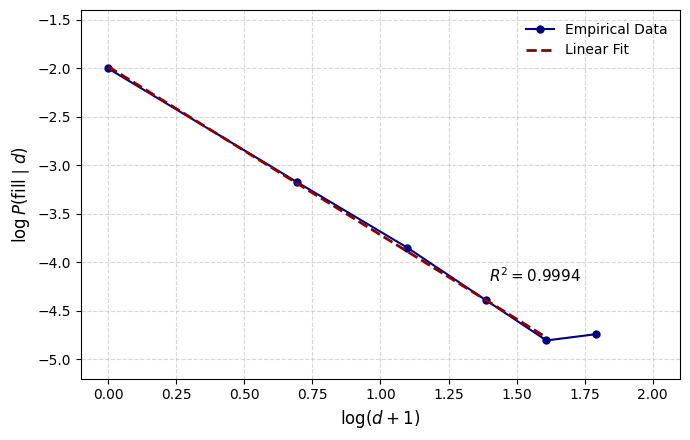

In [15]:
# Copy the Depth and PerDepthFillProbability columns to preserve original data (v2)
x_v2 = depth_data_v2.index.copy()
y_v2 = depth_data_v2['FillProbability'].copy()

# make x_v2 a Pandas Series
x_v2 = pd.Series(x_v2)

# # Drop the first element from the copied data
# x_v2 = x_v2.iloc[1:].reset_index(drop=True)
# y_v2 = y_v2.iloc[1:].reset_index(drop=True)

shift_v2 = 1   # Shift everything by 1

# print adaptive shift info
print(f"Adaptive Shift (v2): {shift_v2:.4f}")

# Add shift to all x values
x_shifted_v2 = x_v2 + shift_v2

# Apply log transformation
x_log_v2 = np.log(x_shifted_v2)
y_log_v2 = np.log(y_v2)

print("After log transformation:")
print(x_log_v2.shape)
print(y_log_v2.shape)


# Fit a linear regression model to the log-log data (v2)
# only first 4 points
x_log_v2_regression = x_log_v2[:5]
y_log_v2_regression = y_log_v2[:4]

print("After slicing:")
print(x_log_v2_regression.shape)
print(y_log_v2_regression.shape)

model_v2 = LinearRegression(fit_intercept=True)
model_v2.fit(x_log_v2_regression.values.reshape(-1, 1), y_log_v2_regression)
slope_v2 = model_v2.coef_[0]
intercept_v2 = model_v2.intercept_

# check r2 score for goodness of fit
r2_score_v2 = model_v2.score(x_log_v2_regression.values.reshape(-1, 1), y_log_v2_regression)
print(f"R2 Score (v2): {r2_score_v2:.4f}")

print(f"Slope (v2): {slope_v2:.4f}, Intercept (v2): {intercept_v2:.4f}")
# Plot setup
plt.figure(figsize=(7, 4.5))

x_fit = x_log_v2_regression.values.reshape(-1, 1)
y_fit = model_v2.predict(x_fit)

# Plot empirical log-log data
plt.plot(
    x_log_v2, y_log_v2, 
    marker='o', 
    markersize=5, 
    linestyle='-', 
    linewidth=1.5, 
    color='navy', 
    label='Empirical Data'
)

# Overlay linear regression line
plt.plot(
    x_log_v2_regression, y_fit, 
    linestyle='--', 
    linewidth=2, 
    color='darkred', 
    label='Linear Fit',
)

# Axes labels using math notation
plt.xlabel(r'$\log(d + 1)$', fontsize=12)
plt.ylabel(r'$\log P(\mathrm{fill} \mid d)$', fontsize=12)

# R-squared annotation
r2_score_v2 = model_v2.score(x_fit, y_log_v2_regression)
plt.text(1.4, -4.2, fr'$R^2 = {r2_score_v2:.4f}$', fontsize=11)

# Aesthetics
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10, frameon=False)
plt.ylim(-5.2, -1.4)
plt.xlim(-0.1, 2.1)
plt.tight_layout()

plt.show()

In [16]:
print(f'Intercept is {np.exp(intercept_v2):.5f} and slope is {slope_v2:.5f}')

Intercept is 0.13773 and slope is -1.73484


In [17]:
# Define the fill prediction function with a cap at 1
# And for depth >= 4, assume a constant fill probability of 1%
def fill_function(x):
    if x < 5:
        return min(np.exp(intercept_v2) * x ** slope_v2, 1)
    else:
        return 0.01

# Make a copy of the dataset for checking
fill_check_df = depth_data_v2.copy()

# Add 1 to the depth index for predictions to account for the shift during calibration
# Assuming 'Index' is the column representing depth
# Generate predictions by adding 1 to the index
fill_check_df['PredictedFill'] = [fill_function(x + 1) for x in fill_check_df.index]


# Drop columns that are not needed
if 'AggFillProbability' in fill_check_df.columns:
    fill_check_df = fill_check_df.drop(columns=['AggFillProbability', 'PerDepthFillProbability'])

# Calculate percentage difference between actual and predicted fill probabilities
fill_check_df['PctDiff'] = ((fill_check_df['FillProbability'] - fill_check_df['PredictedFill']) / fill_check_df['FillProbability']) * 100

# convert FillProbability and PredictedFill to percentage
fill_check_df['FillProbability'] = fill_check_df['FillProbability'] * 100

fill_check_df['PredictedFill'] = fill_check_df['PredictedFill'] * 100

print("Note: all values are quoted in percentage points.")

# Return the dataframe for inspection
fill_check_df


Note: all values are quoted in percentage points.


,PostedOrders,FilledOrders,FillProbability,PredictedFill,PctDiff
Depth,,,,,
0.0,569924944.0,76992788.0,13.509286,13.772557,-1.948821
1.0,185070741.0,7753027.0,4.189224,4.137859,1.226112
2.0,103759343.0,2209878.0,2.129811,2.047790,3.851077
3.0,93719095.0,1163529.0,1.241507,1.243188,-0.135404
4.0,92090504.0,753676.0,0.818408,1.000000,-22.188452
5.0,44262832.0,386457.0,0.873096,1.000000,-14.534947


## Testing: Exponential vs Power Law

Exponential Fit Params:
  A = 13.3533, lambda = 1.0091


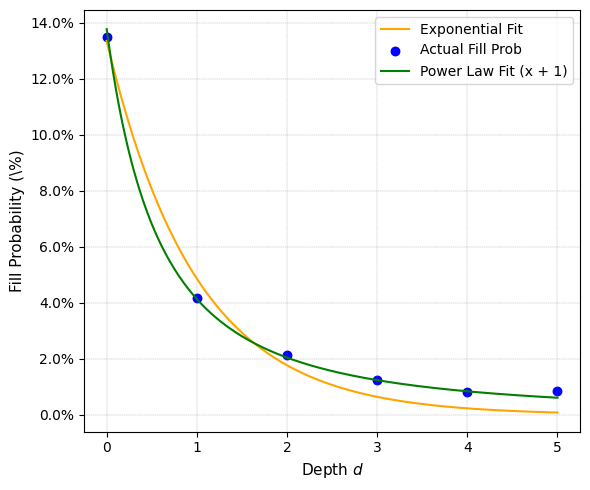

In [18]:
# ------------------------------
# INPUT DATA
# ------------------------------
x = np.array(fill_check_df.index)
y_actual = np.array(fill_check_df['FillProbability'])

# ------------------------------
# EXPONENTIAL MODEL FITTING
# ------------------------------
def exp_model(x, A, lam):
    return A * np.exp(-lam * x)

initial_guess = [13.5, 1.0]
params, _ = curve_fit(exp_model, x, y_actual, p0=initial_guess)
A_fit, lam_fit = params
print(f"Exponential Fit Params:\n  A = {A_fit:.4f}, lambda = {lam_fit:.4f}")

# ------------------------------
# POWER LAW MODEL (x + 1)
# ------------------------------
# 
intercept_v2 = intercept_v2
slope_v2 = slope_v2

def powerlaw_model_fixed(x, intercept, slope):
    return np.minimum(np.exp(intercept) * (x + 1) ** slope, 1) * 100

# ------------------------------
# PLOT COMPARISON
# ------------------------------
x_plot = np.linspace(0, 5, 200)
y_exp_fit = exp_model(x_plot, A_fit, lam_fit)
y_powerlaw_fit = powerlaw_model_fixed(x_plot, intercept_v2, slope_v2)

plt.figure(figsize=(6, 5))
plt.plot(x_plot, y_exp_fit, label='Exponential Fit', color='orange')
plt.scatter(x, y_actual, label='Actual Fill Prob', color='blue', linewidths=1.1)
plt.plot(x_plot, y_powerlaw_fit, label='Power Law Fit (x + 1)', color='green')

plt.xlabel(r'Depth $d$', fontsize=11)
plt.ylabel(r'Fill Probability (\%)', fontsize=11)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(frameon=True, fontsize=10)
plt.grid(color='gray', linestyle='--', linewidth=0.3, alpha=0.7)
plt.tight_layout()
plt.show()

In [19]:
# ------------------------------
# MODEL PREDICTIONS
# ------------------------------
y_exp = exp_model(x, A_fit, lam_fit)
y_powerlaw = powerlaw_model_fixed(x, intercept_v2, slope_v2)


# ------------------------------
# ERROR METRICS
# ------------------------------
rmse_exp = np.sqrt(np.mean((y_exp - y_actual) ** 2))
rmse_powerlaw = np.sqrt(np.mean((y_powerlaw - y_actual) ** 2))

mae_exp = np.mean(np.abs(y_exp - y_actual))
mae_powerlaw = np.mean(np.abs(y_powerlaw - y_actual))

# Adjusted R-squared for Exponential
n = len(y_actual)
p = 2  # Number of parameters: A and lambda, applicable to both models
ss_tot = np.sum((y_actual - np.mean(y_actual))**2)

# Residuals and Total Sum of Squares
ss_res_exp = np.sum((y_actual - y_exp)**2)
# R-squared
r2_exp = 1 - ss_res_exp / ss_tot

adj_r2_exp = 1 - (1 - r2_exp) * (n - 1) / (n - p - 1)

# Residuals and Total Sum of Squares
ss_res_power = np.sum((y_actual - y_powerlaw)**2)

# R-squared
r2_power = 1 - ss_res_power / ss_tot  # use same ss_tot as above

# Adjusted R-squared
adj_r2_power = 1 - (1 - r2_power) * (n - 1) / (n - p - 1)


# ------------------------------
# LOG-LIKELIHOOD ESTIMATION (BINOMIAL APPROX)
# ------------------------------
posted_orders = np.array(fill_check_df['PostedOrders'])
filled_orders = np.array(fill_check_df['FilledOrders'])

p_exp = y_exp / 100
p_powerlaw = y_powerlaw / 100
eps = 1e-12

log_likelihood_exp = np.sum(filled_orders * np.log(p_exp + eps) + (posted_orders - filled_orders) * np.log(1 - p_exp + eps))
log_likelihood_powerlaw = np.sum(filled_orders * np.log(p_powerlaw + eps) + (posted_orders - filled_orders) * np.log(1 - p_powerlaw + eps))

# ------------------------------
# AIC & BIC Computation
# ------------------------------

# Number of parameters
k_exp = 2  # A and lambda
k_powerlaw = 2  # intercept and slope

n = len(x)  # Number of observations

# AIC = 2k - 2LL
aic_exp = 2 * k_exp - 2 * log_likelihood_exp
aic_powerlaw = 2 * k_powerlaw - 2 * log_likelihood_powerlaw

# BIC = k * log(n) - 2LL
bic_exp = k_exp * np.log(n) - 2 * log_likelihood_exp
bic_powerlaw = k_powerlaw * np.log(n) - 2 * log_likelihood_powerlaw

# ------------------------------
# VUONG-LIKE TEST
# ------------------------------
pointwise_llr = filled_orders * (np.log(p_powerlaw + eps) - np.log(p_exp + eps)) + \
                (posted_orders - filled_orders) * (np.log(1 - p_powerlaw + eps) - np.log(1 - p_exp + eps))

mean_llr = np.mean(pointwise_llr)
std_llr = np.std(pointwise_llr, ddof=1)
z_score = mean_llr / (std_llr / np.sqrt(len(x)))


# ------------------------------
# OUTPUT RESULTS
# ------------------------------

print("Exponential Fit Parameters:")
print(f"  A = {A_fit:.4f}, lambda = {lam_fit:.4f}")

print("\nPower Law Fit Parameters:")
print(f"  Intercept = {np.exp(intercept_v2)*100:.4f}, Slope = {slope_v2:.4f}")

print("\nError Metrics:")
print(f"  RMSE (Exponential) = {rmse_exp:.4f}")
print(f"  RMSE (Power Law) = {rmse_powerlaw:.4f}")
print(f"  MAE (Exponential) = {mae_exp:.4f}")
print(f"  MAE (Power Law) = {mae_powerlaw:.4f}")

print("\nUnadjusted Raw R-squared:")
print(f"R-squared (Exponential) = {r2_exp:.4f}")
print(f"R-squared (Power Law) = {r2_power:.4f}")

print("\nAdjusted R-squared:")
print(f"Adjusted R-squared (Exponential) = {adj_r2_exp:.4f}")
print(f"Adjusted R-squared (Power Law) = {adj_r2_power:.4f}")

print("\n\nCAUTION: Following metrics based on likelihood may not be robust with n=5 as in this case.")
print("\nLog-Likelihood:")
print(f"  Exponential: {log_likelihood_exp:.4f}")
print(f"  Power Law: {log_likelihood_powerlaw:.4f}")

print("\nAIC:")
print(f"  Exponential: {aic_exp:.4f}")
print(f"  Power Law: {aic_powerlaw:.4f}")

print("\nBIC:")
print(f"  Exponential: {bic_exp:.4f}")
print(f"  Power Law: {bic_powerlaw:.4f}")

print("\nVuong-like Test:")
print(f"  Mean Log-Likelihood Ratio: {mean_llr:.4f}")
print(f"  Standard Deviation: {std_llr:.4f}")
print(f"  Z-Score: {z_score:.4f}")



Exponential Fit Parameters:
  A = 13.3533, lambda = 1.0091

Power Law Fit Parameters:
  Intercept = 13.7726, Slope = -1.7348

Error Metrics:
  RMSE (Exponential) = 0.5662
  RMSE (Power Law) = 0.1559
  MAE (Exponential) = 0.5257
  MAE (Power Law) = 0.1137

Unadjusted Raw R-squared:
R-squared (Exponential) = 0.9841
R-squared (Power Law) = 0.9988

Adjusted R-squared:
Adjusted R-squared (Exponential) = 0.9736
Adjusted R-squared (Power Law) = 0.9980


CAUTION: Following metrics based on likelihood may not be robust with n=5 as in this case.

Log-Likelihood:
  Exponential: -282687211.6716
  Power Law: -281435558.7513

AIC:
  Exponential: 565374427.3432
  Power Law: 562871121.5025

BIC:
  Exponential: 565374426.9267
  Power Law: 562871121.0860

Vuong-like Test:
  Mean Log-Likelihood Ratio: 208608.8201
  Standard Deviation: 214867.6815
  Z-Score: 2.3781
